In [2]:
import pydicom
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Cargar archivo DICOM
dicom_file = "Imagenes/Left/1-13.dcm"
ds = pydicom.dcmread(dicom_file)





In [4]:
print(f"Dimensiones de la imagen: {ds.Rows} x {ds.Columns} píxeles")
if 'PixelSpacing' in ds:
    print(f"Espaciado de píxeles: {ds.PixelSpacing} mm")
print(f"Profundidad de bits por píxel: {ds.BitsAllocated}")
print(f"Modalidad: {ds.Modality}")
print(f"Tamaño del archivo DICOM: {ds.file_meta.TransferSyntaxUID}")

Dimensiones de la imagen: 4544 x 3080 píxeles
Profundidad de bits por píxel: 16
Modalidad: MG
Tamaño del archivo DICOM: 1.2.840.10008.1.2


In [5]:
# Obtener la matriz de píxeles de la imagen
pixel_array = ds.pixel_array

# Convertir la matriz de píxeles a formato adecuado para imagen
result_image = Image.fromarray(pixel_array)

# Guardar la imagen como PNG
#image.save("imagenes/imagen_convertida1.png")

In [6]:
result_image_array = np.array(result_image)

# Comparar dimensiones
print(f"Dimensiones de la imagen DICOM: {pixel_array.shape}")
print(f"Dimensiones de la imagen convertida: {result_image_array.shape}")

# Comparar los arrays de píxeles
if np.array_equal(pixel_array, result_image_array):
    print("Los arrays de píxeles son iguales.")
else:
    print("Los arrays de píxeles son diferentes.")

Dimensiones de la imagen DICOM: (4544, 3080)
Dimensiones de la imagen convertida: (4544, 3080)
Los arrays de píxeles son iguales.


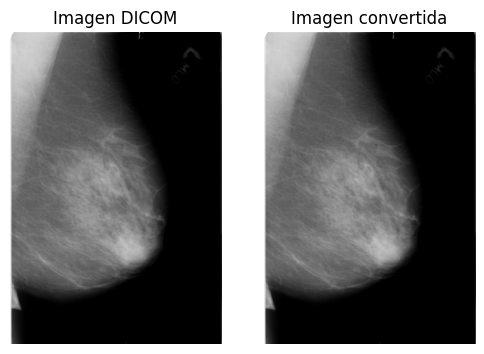

In [7]:
# Mostrar la imagen DICOM
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(pixel_array, cmap='gray')
plt.title('Imagen DICOM')
plt.axis('off')

# Cargar la imagen resultante (PNG, JPEG)
#result_image = Image.open("imagenes/imagen_convertida1.png")

# Mostrar la imagen convertida
plt.subplot(1, 2, 2)
plt.imshow(result_image_array, cmap='gray')
plt.title('Imagen convertida')
plt.axis('off')

plt.show()

In [46]:
def read_imageResize_with_labels(dir='Imagenes', target_size=(224, 224)):
    """
    Lee imágenes de un directorio, las redimensiona a 224x224 píxeles y las etiqueta según 
    la subcarpeta en la que se encuentran. Las imágenes son procesadas en escala de grises.
    
    Parámetros:
    dir (str): La ruta del directorio principal que contiene las subcarpetas con las imágenes. 
               Las subcarpetas deben llamarse 'Left' y 'Right' para que las etiquetas se asignen correctamente.
    
    Retorno:
    tuple: Una tupla que contiene dos elementos:
        - np.array: Un array de NumPy con las imágenes redimensionadas.
        - list: Una lista de etiquetas correspondientes a las imágenes.
    """
    labels = []
    imgs = []

    # Crear el directorio ImagenesConvertidas si no existe
    output_dir = 'Imagenes_convertidas'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Crear subdirectorios Left y Right si no existen
    left_dir = os.path.join(output_dir, 'Left')
    right_dir = os.path.join(output_dir, 'Right')
    
    if not os.path.exists(left_dir):
        os.makedirs(left_dir)
    if not os.path.exists(right_dir):
        os.makedirs(right_dir)

    for subfolder in os.listdir(dir):
        subfolder_path = os.path.join(dir, subfolder)
        for name_image in os.listdir(subfolder_path):
            bandera = False

            # Obtener la etiqueta desde el nombre de la subcarpeta
            if subfolder == 'Left':
                bandera = True
                labels.append(0)
                save_path = left_dir  # Guardar en Left
            elif subfolder == 'Right':
                bandera = True
                labels.append(1)
                save_path = right_dir  # Guardar en Right

            if bandera:
                # Obtenemos la ruta de la imagen
                image_path = os.path.join(subfolder_path, name_image)
                dicom_file = image_path
                image_dicom = pydicom.dcmread(dicom_file)
                pixel_array = image_dicom.pixel_array

                # Normalizar los valores de píxeles de la imagen DICOM para que estén en el rango 0-255
                pixel_array = pixel_array.astype(np.float32)
                pixel_array = (pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array)) * 255.0
                pixel_array = pixel_array.astype(np.uint8)

                # Convertir la matriz de píxeles a formato adecuado para imagen
                result_image = Image.fromarray(pixel_array)

                # Convertir la imagen a escala de grises si no lo está
                if result_image.mode != 'L':
                    result_image = result_image.convert('L')

                # Redimensionar la imagen
                image_resized = result_image.resize(target_size, Image.Resampling.LANCZOS)

                # Guardar la imagen convertida en el directorio correspondiente
                save_filename = f"{os.path.splitext(name_image)[0]}.png"
                image_resized.save(os.path.join(save_path, save_filename))

                # Convertir la imagen a un array NumPy para procesar si es necesario
                image_np = np.array(image_resized)
                imgs.append(image_np)

    return np.array(imgs), labels

In [47]:
imgs,labels= read_imageResize_with_labels(dir='Imagenes')

In [33]:
imgs.shape

(12, 224, 224)

In [8]:
def img_compar(img_original, img_preprocess):
    '''
    Funcion utilizada para comparar la imagen antes y despues del procesmiento
    
    Parametros: 
    - img_original: imagen antes del procesamiento
    - img_preprocess: imagen procesada
    
    Output: La funcion muestra una figura de matplotlib con la imagen original y procesada
    '''
    # Mostrar la imagen original y la imagen preprocesada
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title('Imagen Original')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.imshow(img_preprocess, cmap='gray')
    plt.title('Imagen Preprocesada')
    plt.axis('on')

    plt.show()

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_growing(img, seed_point, threshold=20):
    """
    Realiza el algoritmo de crecimiento de regiones a partir de un punto semilla.
    Mejorado para considerar 8 direcciones y un umbral dinámico.

    Parámetros:
    - img: Imagen en escala de grises.
    - seed_point: Tupla (x, y) con la posición de la semilla.
    - threshold: Umbral de similitud de intensidad.

    Retorna:
    - mask: Máscara binaria de la región crecida.
    """
    rows, cols = img.shape
    mask = np.zeros((rows, cols), np.uint8)  
    visited = np.zeros((rows, cols), np.bool_)  

    
    seed_value = img[seed_point[1], seed_point[0]]
    stack = [seed_point]  

   
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1), (-1, 1), (1, -1)]

    while stack:
        x, y = stack.pop()  # Obtener el siguiente punto a procesar
        if visited[y, x]:
            continue
        visited[y, x] = True  # Marcar el punto como visitado
        mask[y, x] = 255  

        # Examinar los vecinos en las 8 direcciones
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < cols and 0 <= ny < rows and not visited[ny, nx]:
                neighbor_value = img[ny, nx]
                # Expandir la región solo si la diferencia de intensidad es menor o igual al umbral
                if abs(int(neighbor_value) - int(seed_value)) <= threshold:
                    stack.append((nx, ny))

    return mask

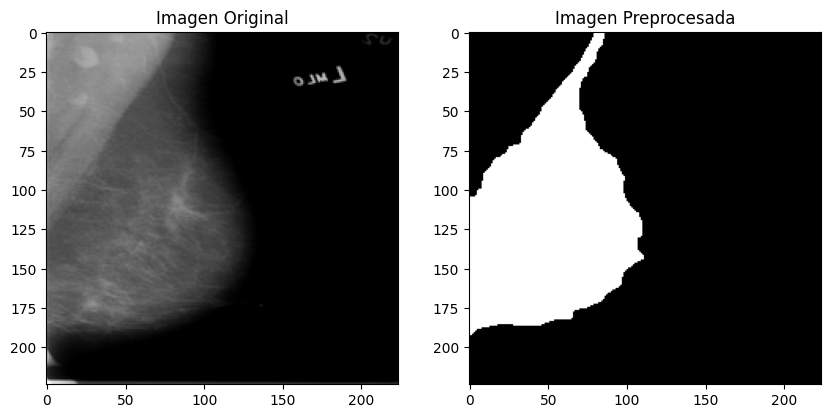

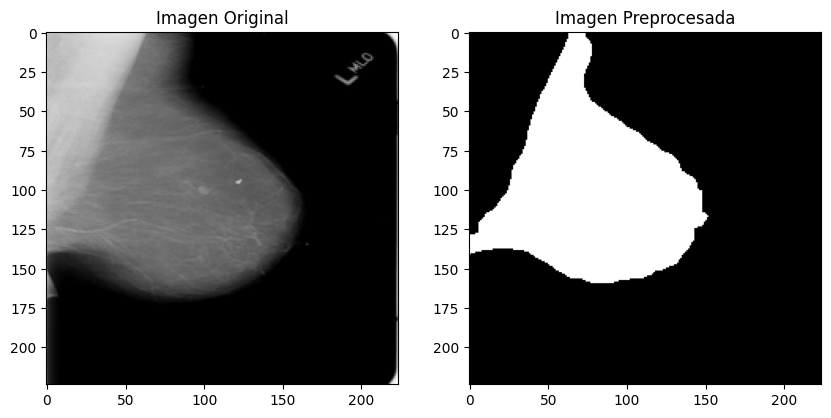

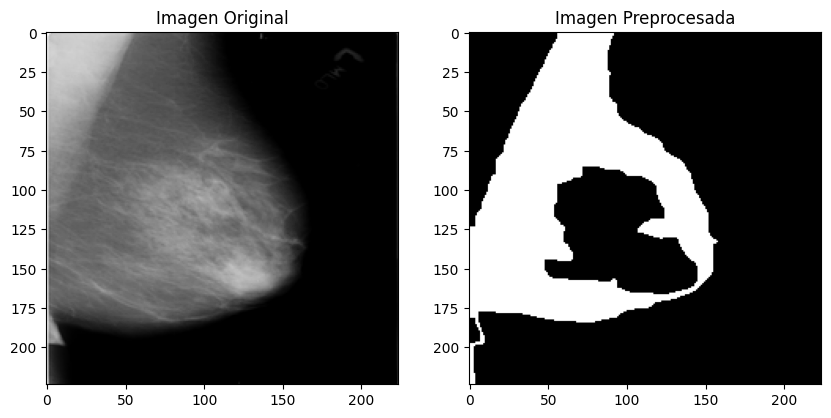

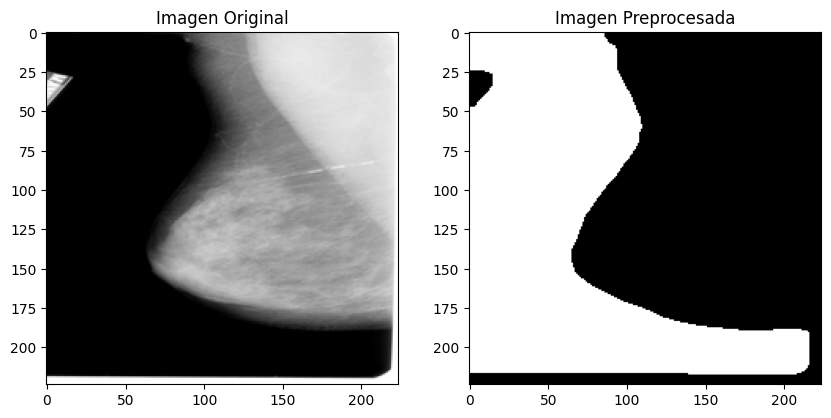

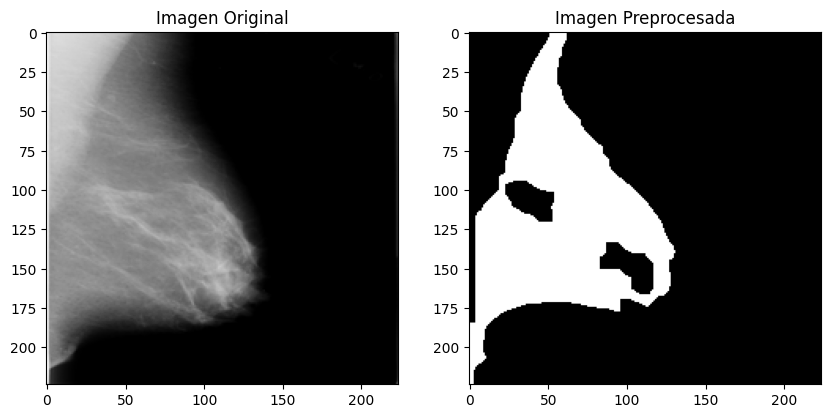

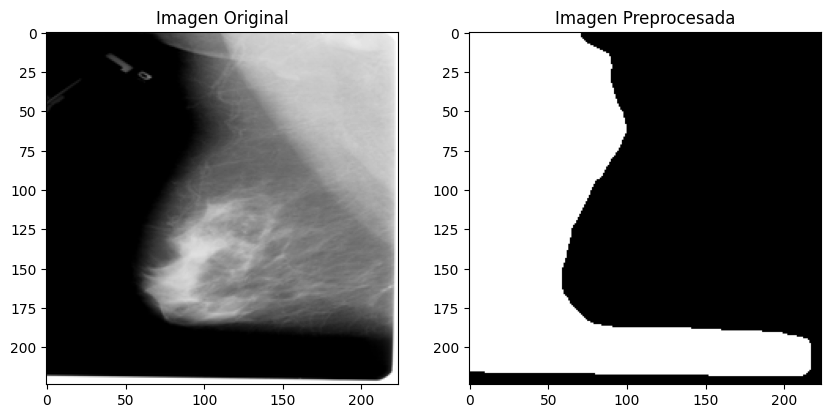

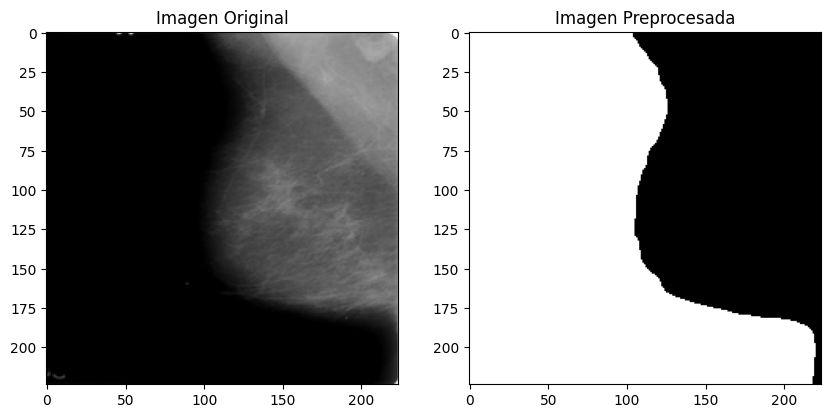

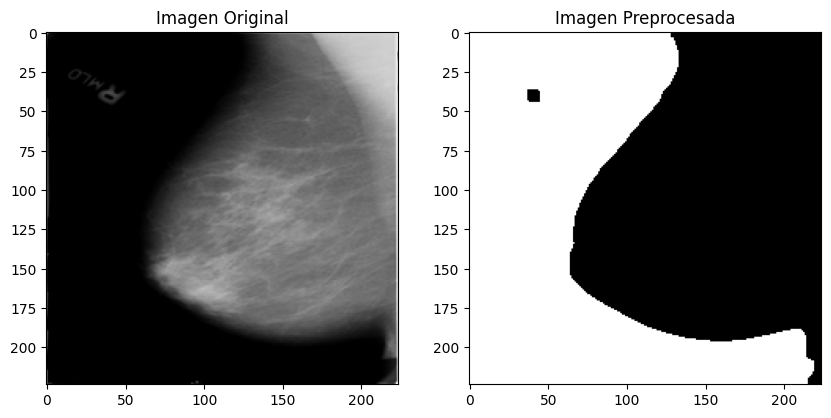

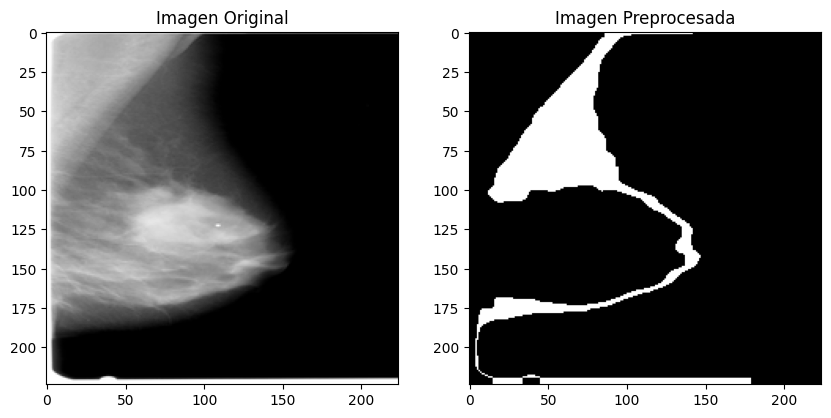

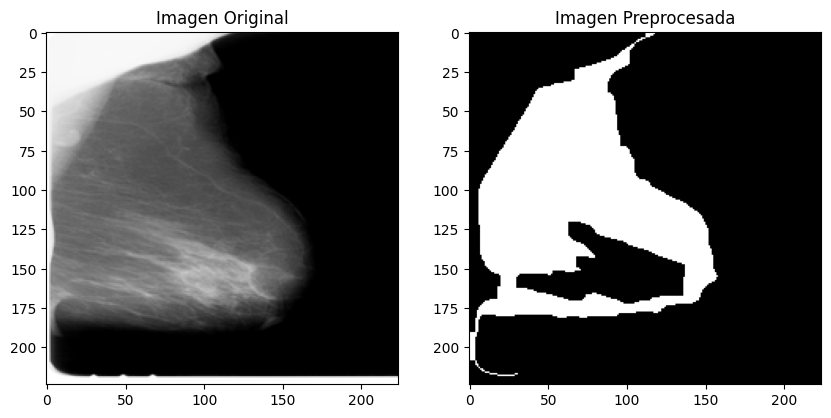

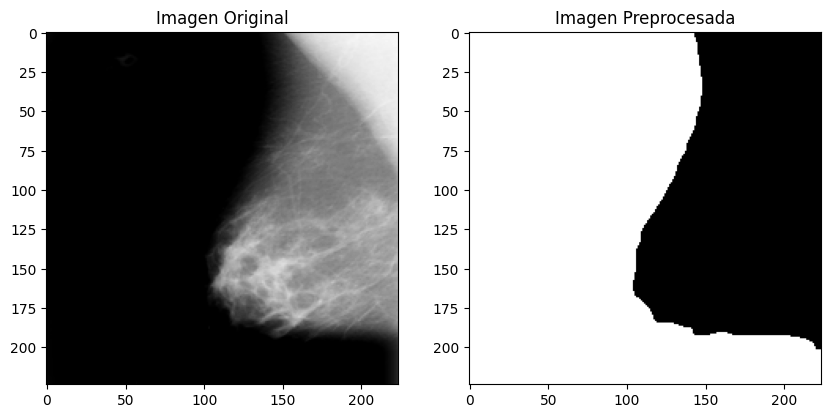

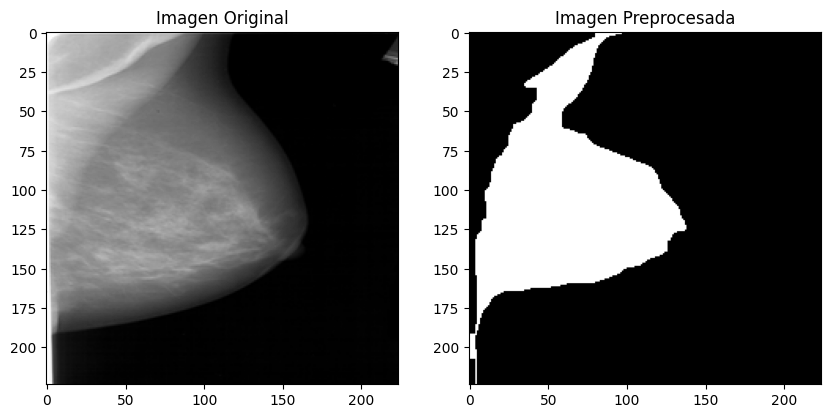

In [39]:

for i in range (len(imgs)):

    img_blur = cv2.GaussianBlur(imgs[i], (9, 9), 0)


    seed_point = (50, 50)  # Coordenadas (x, y)


    mask = region_growing(img_blur, seed_point, threshold=25)



    kernel = np.ones((7, 7), np.uint8)
    mask_morph = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    img_compar(imgs[i],mask_morph)

    mask_inv = cv2.bitwise_not(mask_morph)
    result = cv2.bitwise_and(imgs[i], imgs[i], mask=mask_inv)